#### Import Libraries

In [4]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import re

#### The Main URL Page for Scraping

In [ ]:
top1000_actor_url = "https://www.imdb.com/list/ls058011111/"

#### Read Each IMDB Page

In [231]:
def findNextPageURL(current_html):
    next_link = current_html.find('div', class_ = "footer")
    #print(next_link)
    if not next_link:
        return None
    pn_url = next_link.find_all('a')
    part_url = ''
    for _url in pn_url:
        if re.search(r"Next", _url.text):
            part_url = _url['href']
            
    if part_url == '':
        return None;
        
    response = None
    top1000_actor_url = base_url + part_url
    for attempt in range(10):
        try:
            response = requests.get(top1000_actor_url).text
        except:
            continue
        break
    
    if response:
        next_page_html = bs(response, 'html.parser')
    else:
        return None
    
    return next_page_html
    

#### Find Movies List

In [ ]:
response = requests.get(top1000_actor_url)
top1000_html = bs(response.text, 'html.parser')
base_url = 'https://www.imdb.com/'
top1000actor_list = []
i = 1
while True:
    top1000actor_list = top1000actor_list + top1000_html.find_all('div', class_ = "lister-item mode-detail")
    top1000_html = findNextPageURL(top1000_html)
    if pd.isnull(top1000_html):
        break
    print("page", i, "was read")
    i += 1
print(len(top1000actor_list), "actor page was found")

1
2
3
4


#### Read Each Actor Information

In [98]:
def extract_acttor_information(url):
    actor_info = {}
    try:
        for attemp in range(10):
            try:
                response = requests.get(url)
            except:
                continue
            break;
            
        soup = bs(response.text, 'html.parser')
        
        table = soup.find('table', attrs = {'id': "name-overview-widget-layout"})
        born_info_section = table.find('td', id = 'overview-top').find('div', id = "name-born-info")
        actor_info['Birth Date'] = born_info_section.time.attrs['datetime']
        actor_info['Birth Place'] = born_info_section.time.find_next_sibling('a').text
        
        death_info_section = table.find('td', id = 'overview-top').find('div', id = "name-death-info")
        if death_info_section:
            actor_info['Death Date'] = death_info_section.time.attrs['datetime']
            actor_info['Death Place'] = death_info_section.time.find_next_sibling('a').text
        else:
            actor_info['Death Date'] = None
            actor_info['Death Place'] = None
            
    except error as e: print(e)
    return actor_info

In [1]:
actor_list = []
base_url = 'https://www.imdb.com/'
i = 1
for actor_item in top1000actor_list:
    part_url = actor_item.h3.a['href']
    full_url = base_url + part_url
    actor_info = extract_acttor_information(full_url)
    actor_info['Name'] = actor_item.h3.a.text
    actor_info['URL'] = full_url
    actor_list.append(actor_info)
    print(i, actor_info['Name'])
    i += 1
    
print(len(actor_list), "actor was added to actor_list")

NameError: name 'top1000actor_list' is not defined

In [170]:
len(actor_list)
actor_df = pd.DataFrame(actor_list)
actor_df.head()

,Birth Date,Birth Place,Death Date,Death Place,Name,URL
0,1943-8-17,"New York City, New York, USA",None,None,Robert De Niro\n,https://www.imdb.com//name/nm0000134
1,1937-4-22,"Neptune, New Jersey, USA",None,None,Jack Nicholson\n,https://www.imdb.com//name/nm0000197
2,1924-4-3,"Omaha, Nebraska, USA",2004-7-1,"Westwood, Los Angeles, California, USA",Marlon Brando\n,https://www.imdb.com//name/nm0000008
3,1954-12-28,"Mount Vernon, New York, USA",None,None,Denzel Washington\n,https://www.imdb.com//name/nm0000243
4,1907-5-12,"Hartford, Connecticut, USA",2003-6-29,"Old Saybrook, Connecticut, USA",Katharine Hepburn\n,https://www.imdb.com//name/nm0000031


In [61]:
def save_csv(addr, df):
    df.to_csv(addr, index = False)

In [184]:
addr = r'.\Top1000_Actors_Info.csv'
save_csv(addr , actor_df)

In [1]:
def load_csv(addr):
    return pd.read_csv(addr)

In [5]:
addr = r'.\Top1000_Actors_Info.csv'
actor_df = load_csv(addr)
actor_df.tail(3)

,Birth Date,Birth Place,Death Date,Death Place,Name,URL
997,1939-10-27,"Weston-Super-Mare, Somerset, England, UK",NaN,NaN,John Cleese\n,https://www.imdb.com//name/nm0000092
998,1957-2-28,"Brooklyn, New York City, New York, USA",NaN,NaN,John Turturro\n,https://www.imdb.com//name/nm0001806
999,1926-3-16,"Newark, New Jersey, USA",2017-8-20,"Las Vegas, Nevada, USA",Jerry Lewis\n,https://www.imdb.com//name/nm0001471


#### Clean The Data

In [6]:
actor_df['Name'] = actor_df['Name'].apply(lambda x: x.replace('\n', ''))
actor_df.tail(3)

,Birth Date,Birth Place,Death Date,Death Place,Name,URL
997,1939-10-27,"Weston-Super-Mare, Somerset, England, UK",NaN,NaN,John Cleese,https://www.imdb.com//name/nm0000092
998,1957-2-28,"Brooklyn, New York City, New York, USA",NaN,NaN,John Turturro,https://www.imdb.com//name/nm0001806
999,1926-3-16,"Newark, New Jersey, USA",2017-8-20,"Las Vegas, Nevada, USA",Jerry Lewis,https://www.imdb.com//name/nm0001471


In [7]:
from datetime import datetime
actor_df['Birth Date(Date Time)'] = actor_df['Birth Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
actor_df['Death Date(Date Time)'] = actor_df['Death Date'].apply(lambda x:None if pd.isnull(x) else datetime.strptime(x, '%Y-%m-%d'))
actor_df.tail(3)

,Birth Date,Birth Place,Death Date,Death Place,Name,URL,Birth Date(Date Time),Death Date(Date Time)
997,1939-10-27,"Weston-Super-Mare, Somerset, England, UK",NaN,NaN,John Cleese,https://www.imdb.com//name/nm0000092,1939-10-27,NaT
998,1957-2-28,"Brooklyn, New York City, New York, USA",NaN,NaN,John Turturro,https://www.imdb.com//name/nm0001806,1957-02-28,NaT
999,1926-3-16,"Newark, New Jersey, USA",2017-8-20,"Las Vegas, Nevada, USA",Jerry Lewis,https://www.imdb.com//name/nm0001471,1926-03-16,2017-08-20


In [8]:
actor_df = actor_df[['Name', 'Birth Date', 'Birth Date(Date Time)', 'Birth Place', 'Death Date', 'Death Date(Date Time)', 'Death Place', 'URL']]
actor_df.tail(3)

,Name,Birth Date,Birth Date(Date Time),Birth Place,Death Date,Death Date(Date Time),Death Place,URL
997,John Cleese,1939-10-27,1939-10-27,"Weston-Super-Mare, Somerset, England, UK",NaN,NaT,NaN,https://www.imdb.com//name/nm0000092
998,John Turturro,1957-2-28,1957-02-28,"Brooklyn, New York City, New York, USA",NaN,NaT,NaN,https://www.imdb.com//name/nm0001806
999,Jerry Lewis,1926-3-16,1926-03-16,"Newark, New Jersey, USA",2017-8-20,2017-08-20,"Las Vegas, Nevada, USA",https://www.imdb.com//name/nm0001471


In [183]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def calculate_age(y):
    today_date = datetime.now()
    if pd.isnull(y[1]):
        return relativedelta(today_date, y[0]).years
    else:
        return relativedelta(y[1], y[0]).years
        
actor_df['Age'] = actor_df[['Birth Date(Date Time)', 'Death Date(Date Time)']].apply(lambda x: calculate_age(x), axis=1)
actor_df.tail(5)

,Name,Birth Date,Birth Date(Date Time),Birth Place,Death Date,Death Date(Date Time),Death Place,URL,Age
995,Adam Driver,1983-11-19,1983-11-19,"San Diego, California, USA",NaN,NaT,NaN,https://www.imdb.com//name/nm3485845,37
996,Ned Beatty,1937-7-6,1937-07-06,"Louisville, Kentucky, USA",2021-6-13,2021-06-13,"Los Angeles, California, USA",https://www.imdb.com//name/nm0000885,83
997,John Cleese,1939-10-27,1939-10-27,"Weston-Super-Mare, Somerset, England, UK",NaN,NaT,NaN,https://www.imdb.com//name/nm0000092,81
998,John Turturro,1957-2-28,1957-02-28,"Brooklyn, New York City, New York, USA",NaN,NaT,NaN,https://www.imdb.com//name/nm0001806,64
999,Jerry Lewis,1926-3-16,1926-03-16,"Newark, New Jersey, USA",2017-8-20,2017-08-20,"Las Vegas, Nevada, USA",https://www.imdb.com//name/nm0001471,91


In [ ]:
addr = r'.\Top1000_Actors_Info_cleaned.csv'
save_csv(addr , actor_df)

#### Analyze the Data

In [194]:
actor_df[pd.notnull(actor_df['Death Date'])].sort_values(['Age', 'Death Date(Date Time)'], ascending = True).head(10)

,Name,Birth Date,Birth Date(Date Time),Birth Place,Death Date,Death Date(Date Time),Death Place,URL,Age
814,River Phoenix,1970-8-23,1970-08-23,"Madras, Oregon, USA",1993-10-31,1993-10-31,"West Hollywood, California, USA",https://www.imdb.com//name/nm0000203,23
52,James Dean,1931-2-8,1931-02-08,"Marion, Indiana, USA",1955-9-30,1955-09-30,"Cholame, California, USA",https://www.imdb.com//name/nm0000015,24
243,Jean Harlow,1911-3-3,1911-03-03,"Kansas City, Missouri, USA",1937-6-7,1937-06-07,"Los Angeles, California, USA",https://www.imdb.com//name/nm0001318,26
87,Heath Ledger,1979-4-4,1979-04-04,"Perth, Western Australia, Australia",2008-1-22,2008-01-22,"Manhattan, New York City, New York, USA",https://www.imdb.com//name/nm0005132,28
64,Bruce Lee,1940-11-27,1940-11-27,"San Francisco, California, USA",1973-7-20,1973-07-20,"Kowloon, Hong Kong",https://www.imdb.com//name/nm0000045,32
241,Carole Lombard,1908-10-6,1908-10-06,"Fort Wayne, Indiana, USA",1942-1-16,1942-01-16,"Potosi Mountain, Nevada, USA",https://www.imdb.com//name/nm0001479,33
25,Marilyn Monroe,1926-6-1,1926-06-01,"Los Angeles, California, USA",1962-8-5,1962-08-05,"Los Angeles, California, USA",https://www.imdb.com//name/nm0000054,36
748,Jean Seberg,1938-11-13,1938-11-13,"Marshalltown, Iowa, USA",1979-8-30,1979-08-30,"Paris, France",https://www.imdb.com//name/nm0781029,40
506,Paul Walker,1973-9-12,1973-09-12,"Glendale, California, USA",2013-11-30,2013-11-30,"Valencia, Santa Clarita, California, USA",https://www.imdb.com//name/nm0908094,40
948,Elvis Presley,1935-1-8,1935-01-08,"Tupelo, Mississippi, USA",1977-8-16,1977-08-16,"Memphis, Tennessee, USA",https://www.imdb.com//name/nm0000062,42


In [208]:
actor_df['Country'] = actor_df['Birth Place'].apply(lambda x: x.split(',')[-1])
actor_df.head(10)

,Name,Birth Date,Birth Date(Date Time),Birth Place,Death Date,Death Date(Date Time),Death Place,URL,Age,Country
0,Robert De Niro,1943-8-17,1943-08-17,"New York City, New York, USA",NaN,NaT,NaN,https://www.imdb.com//name/nm0000134,77,USA
1,Jack Nicholson,1937-4-22,1937-04-22,"Neptune, New Jersey, USA",NaN,NaT,NaN,https://www.imdb.com//name/nm0000197,84,USA
2,Marlon Brando,1924-4-3,1924-04-03,"Omaha, Nebraska, USA",2004-7-1,2004-07-01,"Westwood, Los Angeles, California, USA",https://www.imdb.com//name/nm0000008,80,USA
3,Denzel Washington,1954-12-28,1954-12-28,"Mount Vernon, New York, USA",NaN,NaT,NaN,https://www.imdb.com//name/nm0000243,66,USA
4,Katharine Hepburn,1907-5-12,1907-05-12,"Hartford, Connecticut, USA",2003-6-29,2003-06-29,"Old Saybrook, Connecticut, USA",https://www.imdb.com//name/nm0000031,96,USA
5,Humphrey Bogart,1899-12-25,1899-12-25,"New York City, New York, USA",1957-1-14,1957-01-14,"Los Angeles, California, USA",https://www.imdb.com//name/nm0000007,57,USA
6,Meryl Streep,1949-6-22,1949-06-22,"Summit, New Jersey, USA",NaN,NaT,NaN,https://www.imdb.com//name/nm0000658,72,USA
7,Daniel Day-Lewis,1957-4-29,1957-04-29,"Greenwich, London, England, UK",NaN,NaT,NaN,https://www.imdb.com//name/nm0000358,64,UK
8,Sidney Poitier,1927-2-20,1927-02-20,"Miami, Florida, USA",NaN,NaT,NaN,https://www.imdb.com//name/nm0001627,94,USA
9,Clark Gable,1901-2-1,1901-02-01,"Cadiz, Ohio, USA",1960-11-16,1960-11-16,"Los Angeles, California, USA",https://www.imdb.com//name/nm0000022,59,USA


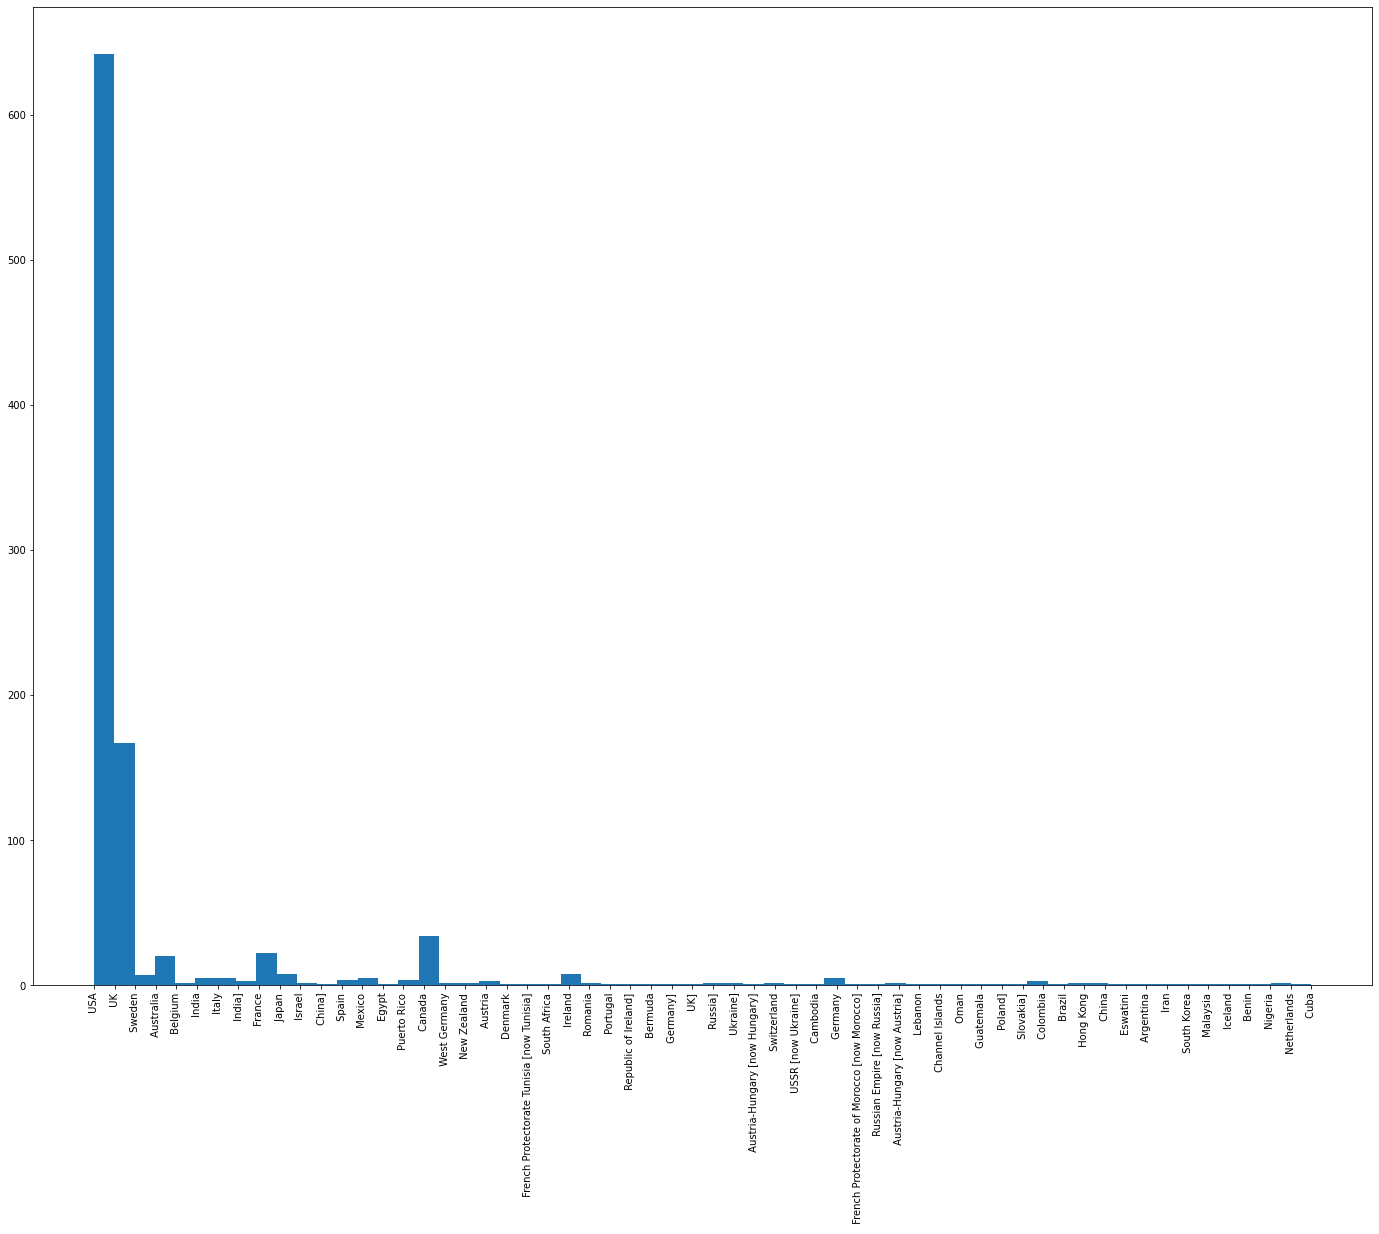

In [230]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 18))
plt.hist(actor_df['Country'], bins = len(actor_df['Country'].unique()))
plt.xticks(rotation=90)
plt.show()